In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from datetime import datetime as dt
import glob
import itertools
import os
import random

from pathlib import Path
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
#from tensorflow.keras.applications import EfficientNetB2, ResNet50, Xception
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, TensorBoard 
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix


In [2]:
training_path = Path('../input/10-monkey-species/training/training/')
validation_path = Path('../input/10-monkey-species/validation/validation/')

In [3]:
columns = ['Label', 'Latin Name', 'Common Name', 'Train Image', 'Validation Image']
labels = pd.read_csv('../input/10-monkey-species/monkey_labels.txt', names=columns, skiprows=1)
labels

,Label,Latin Name,Common Name,Train Image,Validation Image
0,n0,alouatta_palliata\t,mantled_howler,131,26
1,n1,erythrocebus_patas\t,patas_monkey,139,28
2,n2,cacajao_calvus\t,bald_uakari,137,27
3,n3,macaca_fuscata\t,japanese_macaque,152,30
4,n4,cebuella_pygmea\t,pygmy_marmoset,131,26
5,n5,cebus_capucinus\t,white_headed_capuchin,141,28
6,n6,mico_argentatus\t,silvery_marmoset,132,26
7,n7,saimiri_sciureus\t,common_squirrel_monkey,142,28
8,n8,aotus_nigriceps\t,black_headed_night_monkey,133,27
9,n9,trachypithecus_johnii,nilgiri_langur,132,26


In [4]:
def show_images(num_to_show, folder):
    for i in range(num_to_show):
        image_path= Path('../input/10-monkey-species/training/training/' + folder)
        image_number = random.choice(os.listdir(image_path))
        image = cv2.imread('../input/10-monkey-species/training/training/'+ folder +'/'+ image_number)
        print(image.shape)
        plt.figure(i)
        plt.imshow(image)
        plt.title(image_number)
    plt.show()

 black_headed_night_monkey     
(660, 440, 3)
(349, 353, 3)
(1024, 678, 3)


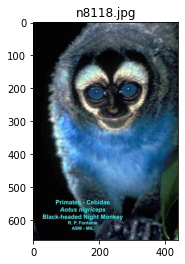

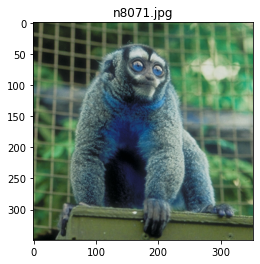

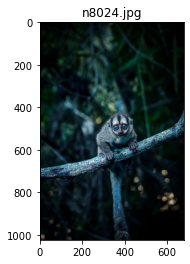

In [5]:
print(labels['Common Name'][8])
show_images(3, 'n8')

In [6]:
height, width, channels = 150, 150, 3
batch_size = 16
seed = 42
num_classes = 10
epochs =57


train_datagen = ImageDataGenerator(rescale=1/255, horizontal_flip=True, rotation_range=40, zoom_range=0.2, shear_range=0.2, fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(training_path, target_size=(height, width), batch_size = batch_size, seed = seed, shuffle=True, class_mode = 'categorical')


validation_datagen = ImageDataGenerator(rescale=1/255)
validation_generator = validation_datagen.flow_from_directory(validation_path, target_size=(height, width), batch_size = batch_size, seed = seed, shuffle=False, class_mode = 'categorical')

total_train = train_generator.samples
total_validation =validation_generator.samples

Found 1098 images belonging to 10 classes.
Found 272 images belonging to 10 classes.


In [7]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(height, width, channels)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [8]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        1

In [9]:
reduce_learning_rate = ReduceLROnPlateau(monitor='loss',
                                         factor=0.1,
                                         patience=2,
                                         cooldown=2,
                                         min_lr=0.00001,
                                         verbose=1)
#filepath=str(os.getcwd()+"/model.h5f")
#checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
#tensorboard_callback = TensorBoard(log_dir='../output/logs', batch_size=batch_size)
callbacks=[reduce_learning_rate,]# checkpoint]#, tensorboard_callback]

In [10]:
history = model.fit_generator(train_generator,
                              steps_per_epoch= total_train // batch_size,
                              epochs=epochs,
                              validation_data=validation_generator,
                              validation_steps= total_validation// batch_size,
                              callbacks=callbacks, 
                              verbose = 1
                             )

Epoch 1/57
68/68 [==============================] - 74s 1s/step - loss: 2.2935 - acc: 0.1359 - val_loss: 2.1862 - val_acc: 0.1985
Epoch 2/57
68/68 [==============================] - 55s 802ms/step - loss: 2.1205 - acc: 0.2024 - val_loss: 1.9647 - val_acc: 0.2096
Epoch 3/57
68/68 [==============================] - 56s 818ms/step - loss: 1.9613 - acc: 0.2542 - val_loss: 1.8207 - val_acc: 0.2941
Epoch 4/57
68/68 [==============================] - 54s 789ms/step - loss: 1.8575 - acc: 0.3170 - val_loss: 1.7950 - val_acc: 0.3235
Epoch 5/57
68/68 [==============================] - 54s 795ms/step - loss: 1.7463 - acc: 0.3697 - val_loss: 1.6010 - val_acc: 0.3787
Epoch 6/57
68/68 [==============================] - 53s 780ms/step - loss: 1.6975 - acc: 0.3826 - val_loss: 1.4845 - val_acc: 0.4265
Epoch 7/57
68/68 [==============================] - 56s 820ms/step - loss: 1.6422 - acc: 0.4067 - val_loss: 1.4442 - val_acc: 0.4669
Epoch 8/57
68/68 [==============================] - 55s 811ms/step - los

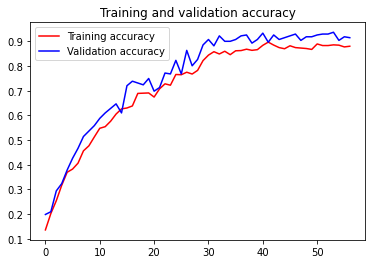

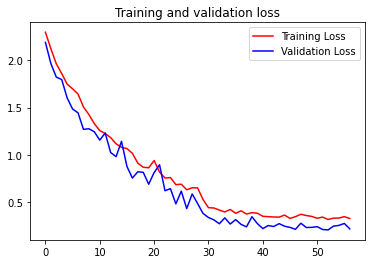

In [11]:
# Plot the chart for accuracy and loss on both training and validation
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()